In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, isnan, count, when, isnull, size, split
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, FloatType, DateType
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('fine_tune_random_forest_attempt_feature_importance_7_2').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 04:18:25 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/14 04:18:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/14 04:18:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/04/14 04:18:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Load the baseline model

trainingDataPath = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/trainingDataTransformed_3.parquet"
testDataPath = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/dataWithZeroReviewTransformed_3.parquet"


# Load the data if necessary
reviews_data = spark.read.parquet(trainingDataPath)
zero_review_data = spark.read.parquet(testDataPath)


In [4]:
reviews_data.head(1)

[Row(host_total_listings_count=3.0, accommodates=8, num_bath=3.0, bedrooms=4.0, beds=6.0, price=500.0, amenities_count=14, essential_amenities=3, host_is_superhost='t', city='Broward County', room_type='Entire home/apt', full_time_host='f', host_verifications_clean='ep', target='Great', host_is_superhost_indexed=1.0, city_indexed=1.0, full_time_host_indexed=0.0, features=DenseVector([1.0, 1.0, 0.0, 3.0, 8.0, 500.0, 14.0]), target_label=0.0)]

In [5]:
zero_review_data.head(1)

24/04/14 04:18:52 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(id=827736378366911479, host_id=475630606, host_since='2022-08-18', host_location='Unknown', host_is_superhost='f', host_listings_count=1.0, host_total_listings_count=3.0, host_has_profile_pic='t', host_identity_verified='t', neighborhood='Fort Lauderdale', latitude=26.09393643124416, longitude=-80.13759087771177, room_type='Entire home/apt', accommodates=2, num_bath=1.0, bedrooms=1.0, beds=1.0, price=222.0, calculated_host_listings_count=1, city='Broward County', amenities_count=10, neighborhood_city='Fort Lauderdale Broward County', full_time_host='f', host_verifications_clean='p', essential_amenities=3, host_is_superhost_indexed=0.0, city_indexed=1.0, full_time_host_indexed=0.0, features=DenseVector([0.0, 1.0, 0.0, 3.0, 2.0, 222.0, 10.0]))]

In [6]:
train_data,test_data = reviews_data.randomSplit([0.7,0.3], seed=42)

In [7]:
# Initialize a new RandomForestClassifier
rfc = RandomForestClassifier(labelCol='target_label', featuresCol='features', maxBins=2200)


In [8]:
# Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rfc.numTrees, [22])
             .addGrid(rfc.maxDepth, [12])
             .build())

evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

# Setup the CrossValidator
cv = CrossValidator(estimator=rfc,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

In [9]:
# Fit the CrossValidator to the training data
cv_model = cv.fit(train_data)


24/04/14 04:19:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1640.8 KiB
24/04/14 04:19:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/04/14 04:19:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/04/14 04:19:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/04/14 04:19:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1257.0 KiB
24/04/14 04:19:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/04/14 04:19:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1660.2 KiB
24/04/14 04:19:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/04/14 04:19:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task

In [10]:
# Use the best model to make predictions on the test data
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

# Evaluate the best model's accuracy on the test data
accuracy = evaluator.evaluate(predictions)
print('Best Model Accuracy: {:.2f}%'.format(accuracy * 100))


24/04/14 04:22:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Best Model Accuracy: 59.65%


In [17]:
# # Specify the path where you want to save the model
# model_path = "gs://ds5460-tlee-spring2024/notebooks/jupyter//data/usa/combined_datasets/rfc_test_10features"

# # Save the model
# best_model.save(model_path)

24/04/14 03:49:42 WARN org.apache.spark.scheduler.TaskSetManager: Stage 260 contains a task of very large size (2824 KiB). The maximum recommended task size is 1000 KiB.


In [12]:
# Define the original lists of string and numeric features
stringFeatures = ['host_is_superhost', 'city', 'full_time_host']

numericFeatures = ['host_total_listings_count', 'accommodates', 'price', 'amenities_count',
                  'beds', 'num_bath']

# Create the full list of feature names as they are used in the model
indexed_string_features = [f"{feature}_indexed" for feature in stringFeatures]
feature_names = indexed_string_features + numericFeatures

# Print feature names
print("Feature names used in the model:")
for name in feature_names:
    print(name)

Feature names used in the model:
host_is_superhost_indexed
city_indexed
full_time_host_indexed
host_total_listings_count
accommodates
price
amenities_count
beds
num_bath


In [13]:
feature_names = ['host_is_superhost_indexed', 'city_indexed', 'full_time_host_indexed', 
                 'host_total_listings_count', 'accommodates',
                 'price', 'amenities_count']

# Retrieve feature importances from the model
importances = best_model.featureImportances

# Convert feature importances to a list for easier manipulation
importances_list = importances.toArray()

# Create a list of tuples (featureName, importance) and sort them by importance
feature_importance_list = sorted(zip(feature_names, importances_list), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance:.4f}")


host_total_listings_count: 0.2804
amenities_count: 0.1704
price: 0.1666
city_indexed: 0.1396
host_is_superhost_indexed: 0.1385
accommodates: 0.0782
full_time_host_indexed: 0.0263


### Feature Importance Meaning
Code shows host_total_listings_count and amenities_count are most important

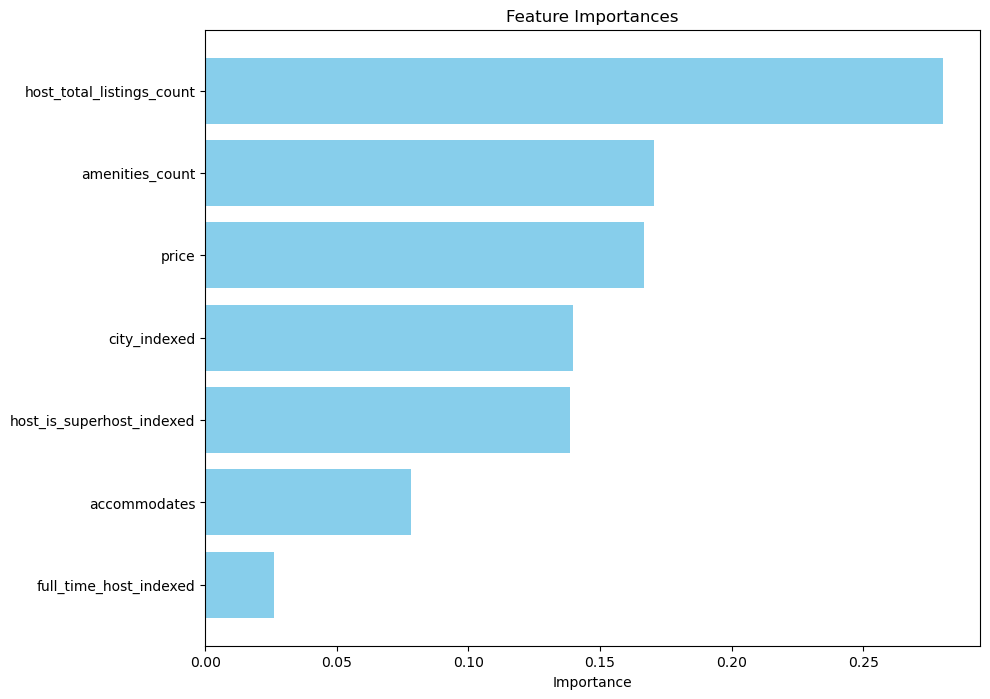

In [14]:
# Create a DataFrame from the feature importances
df_importances = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
df_importances.sort_values(by='Importance', ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [15]:
spark.stop()